In [1]:
%conda info


     active environment : base
    active env location : /opt/conda
            shell level : 1
       user config file : /opt/ml/.condarc
 populated config files : 
          conda version : 4.9.2
    conda-build version : 3.18.11
         python version : 3.7.10.final.0
       virtual packages : __cuda=10.1=0
                          __glibc=2.27=0
                          __unix=0=0
                          __archspec=1=x86_64
       base environment : /opt/conda  (writable)
           channel URLs : https://repo.anaconda.com/pkgs/main/linux-64
                          https://repo.anaconda.com/pkgs/main/noarch
                          https://repo.anaconda.com/pkgs/r/linux-64
                          https://repo.anaconda.com/pkgs/r/noarch
          package cache : /opt/conda/pkgs
                          /opt/ml/.conda/pkgs
       envs directories : /opt/conda/envs
                          /opt/ml/.conda/envs
               platform : linux-64
             user-agent : co

# VGG19 batch norm 기반 모델

In [2]:
import os
from pathlib import Path

BASE_DIR = Path('.').resolve().parent
BASE_DIR

PosixPath('/opt/ml')

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader, Subset
import torch.optim as optim

import torchvision
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [5]:
import random

seed = 123

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)
random.seed(seed)

# TODO: seed_everything도 util로 만들어놓기

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [7]:
from tqdm import tqdm

In [8]:
import warnings 
warnings.filterwarnings('ignore')

## hyperparams

In [9]:
df_path = BASE_DIR / 'output' / 'all_df.pkl'
df = pd.read_pickle(df_path)

model_name = 'VGG19'
use_pretrained = True
freeze_backbone = False

val_split = 0.4
batch_size = 2
num_workers = 0
num_classes = 18

num_epochs = 64
lr = 1e-4
lr_decay_step = 10

train_log_interval = 20
name = 'vgg_based'

## Load Dataset, Dataloader

In [10]:
class MaskDataset(Dataset):
    def __init__(self, pkl_path, transform=None, target_transform=None):
        self.df = pd.read_pickle(pkl_path)
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        row = self.df.iloc[idx, :]
        img_name = row['path'] + row['filename']
        img_path = row['filepath']
        img_np = mpimg.imread(img_path) # H, W, C
        
        label_gender = row['gender_code'] # TODO: 미리 category 숫자로 바꿔놓아야 한다. 
        label_age = row['age']
        label_mask = row['mask_code']
        label_cat = row['cat_code']
        
        if self.transform:
            image = self.transform(image=img_np)
        if self.target_transform:
            pass
        
        sample = {'image': img_np, 'gender': label_gender, 'age': label_age, 'mask': label_mask, 'label': label_cat}
#         sample = {'image': img_np, 'label': label_cat}
        
        return sample

In [11]:
mask_dataset = MaskDataset(pkl_path=df_path,)
len(mask_dataset)

18900

In [12]:
%%time

transform = A.Compose([
    A.RandomCrop(width=200, height=300),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(),
    ToTensorV2(), 
])

transformed_dataset = MaskDataset(pkl_path=df_path, transform=transform)

CPU times: user 364 ms, sys: 0 ns, total: 364 ms
Wall time: 365 ms


In [13]:
%%time

dataloader = DataLoader(transformed_dataset, batch_size=32, shuffle=True, num_workers=10)
dataloader

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 97.8 µs


## Model

### Define model

In [14]:
model = torchvision.models.vgg19_bn(pretrained=True)
model.classifier = nn.Sequential(
    nn.Linear(512 * 7 * 7, 4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(),
    nn.Linear(4096, 4096),
    nn.Dropout(),
    nn.Linear(4096, num_classes),
)

model.features.requires_grad_(False)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU(inplace=True)
  (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU(inplace=True)
  (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

In [15]:
sample_img = mask_dataset[0]['image']
sample_img.shape

(512, 384, 3)

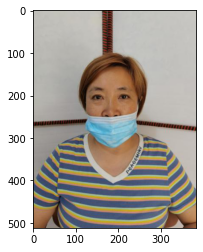

In [16]:
plt.imshow(sample_img)

### Initialize parameters

In [17]:
# Check parameters

with np.printoptions(precision=3):
    total_param = 0
    
    for param_idx, (param_name, param) in enumerate(model.named_parameters()):
        if param.requires_grad:
            param_np = param.detach().cpu().numpy()
            n_param = np.product(param.shape)
            total_param += n_param
            
            print(f'{param_idx} | {param_name} | {param.shape} | {n_param}')
            print(param[:2])

64 | classifier.0.weight | torch.Size([4096, 25088]) | 102760448
tensor([[-0.0030, -0.0036, -0.0059,  ..., -0.0020, -0.0024,  0.0053],
        [-0.0003, -0.0013,  0.0004,  ..., -0.0049, -0.0036, -0.0044]],
       grad_fn=<SliceBackward>)
65 | classifier.0.bias | torch.Size([4096]) | 4096
tensor([-0.0028,  0.0031], grad_fn=<SliceBackward>)
66 | classifier.3.weight | torch.Size([4096, 4096]) | 16777216
tensor([[ 0.0121, -0.0107, -0.0002,  ..., -0.0036,  0.0139,  0.0002],
        [ 0.0144, -0.0035, -0.0119,  ...,  0.0033, -0.0102,  0.0114]],
       grad_fn=<SliceBackward>)
67 | classifier.3.bias | torch.Size([4096]) | 4096
tensor([-0.0004,  0.0036], grad_fn=<SliceBackward>)
68 | classifier.5.weight | torch.Size([18, 4096]) | 73728
tensor([[ 0.0152,  0.0074,  0.0142,  ..., -0.0118, -0.0057, -0.0119],
        [ 0.0110, -0.0067, -0.0050,  ..., -0.0139,  0.0060,  0.0048]],
       grad_fn=<SliceBackward>)
69 | classifier.5.bias | torch.Size([18]) | 18
tensor([ 0.0110, -0.0066], grad_fn=<SliceB

In [18]:
# Initialize parameters

for m in model.modules():
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight)
        nn.init.zeros_(m.bias)


In [19]:
# Check parameters

with np.printoptions(precision=3):
    total_param = 0
    
    for param_idx, (param_name, param) in enumerate(model.named_parameters()):
        if param.requires_grad:
            param_np = param.detach().cpu().numpy()
            n_param = np.product(param.shape)
            total_param += n_param
            
            print(f'{param_idx} | {param_name} | {param.shape} | {n_param}')
            print(param[:2])

64 | classifier.0.weight | torch.Size([4096, 25088]) | 102760448
tensor([[-2.1360e-05, -2.1142e-02,  7.0124e-03,  ...,  1.1617e-02,
         -5.0414e-03,  9.2589e-03],
        [-1.4099e-02, -9.3115e-03,  3.5792e-03,  ..., -2.2065e-02,
         -2.8509e-03,  1.3414e-02]], grad_fn=<SliceBackward>)
65 | classifier.0.bias | torch.Size([4096]) | 4096
tensor([0., 0.], grad_fn=<SliceBackward>)
66 | classifier.3.weight | torch.Size([4096, 4096]) | 16777216
tensor([[ 2.7362e-03,  1.6073e-02,  4.2078e-03,  ..., -2.1853e-03,
          1.9446e-02,  3.4250e-03],
        [-2.6390e-02, -3.8245e-02,  6.2452e-05,  ...,  1.4627e-02,
          1.4495e-02, -1.9928e-02]], grad_fn=<SliceBackward>)
67 | classifier.3.bias | torch.Size([4096]) | 4096
tensor([0., 0.], grad_fn=<SliceBackward>)
68 | classifier.5.weight | torch.Size([18, 4096]) | 73728
tensor([[-0.0160,  0.0071, -0.0246,  ..., -0.0338, -0.0193, -0.0200],
        [-0.0033,  0.0003,  0.0198,  ...,  0.0036, -0.0065,  0.0125]],
       grad_fn=<SliceBa

### Define loss and optimizer

In [20]:
loss = nn.CrossEntropyLoss()
loss

CrossEntropyLoss()

In [21]:
optimizer = optim.Adam(model.parameters(), lr=lr)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 0
)

## Train

In [54]:
def func_eval(model, data_iter, device):
    with torch.no_grad():
        n_total = 0
        n_correct = 0
        
        # To eval mode
        model.eval()
        
        for data in data_iter:
            
            batch_in = data['image'].float().to(device)
            batch_out = data['label']
            
            y_trgt = batch_out.to(device)
            
            model_pred = model(batch_in.view(-1, 3, 512, 384).to(device))
            _, y_pred = torch.max(model_pred.data, 1)
            
            n_correct += (y_pred == y_trgt).sum().item()
            n_total += batch_in.size(0)
        
        val_accr = (n_correct / n_total)
        
        # back to train mode
        model.train()
        
    return val_accr

In [55]:
train_accr = func_eval(model, dataloader, device)
train_accr

RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 47, in fetch
    return self.collate_fn(data)
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/_utils/collate.py", line 74, in default_collate
    return {key: default_collate([d[key] for d in batch]) for key in elem}
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/_utils/collate.py", line 74, in <dictcomp>
    return {key: default_collate([d[key] for d in batch]) for key in elem}
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/_utils/collate.py", line 64, in default_collate
    return default_collate([torch.as_tensor(b) for b in batch])
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/_utils/collate.py", line 55, in default_collate
    return torch.stack(batch, 0, out=out)
RuntimeError: Expected object of scalar type Float but got scalar type Byte for sequence element 1 in sequence argument at position #1 'tensors'


In [61]:
for a in dataloader:
    batchin = a['image']
    batchout = a['label']
    
    print(type(batchin))
    
    print(type(batchout))
    
    print(batchout)
    
    break

<class 'torch.Tensor'>
<class 'torch.Tensor'>
tensor([10,  7,  4, 17], dtype=torch.int8)


In [63]:
df.cat_code.unique()

array([ 0,  1,  2,  9, 10, 11,  6,  7,  8, 15, 16, 17, 12, 13, 14,  3,  4,
        5], dtype=int8)

In [68]:
img = mask_dataset[0]['image']
label = mask_dataset[0]['label']
label

0

In [69]:
img

array([[[191, 190, 185],
        [191, 190, 185],
        [191, 190, 185],
        ...,
        [201, 200, 195],
        [201, 200, 195],
        [201, 200, 195]],

       [[191, 190, 185],
        [191, 190, 185],
        [191, 190, 185],
        ...,
        [201, 200, 195],
        [201, 200, 195],
        [201, 200, 195]],

       [[191, 190, 185],
        [191, 190, 185],
        [191, 190, 185],
        ...,
        [201, 200, 195],
        [201, 200, 195],
        [201, 200, 195]],

       ...,

       [[149,  97,  60],
        [150,  98,  61],
        [150,  98,  61],
        ...,
        [151,  94,  64],
        [151,  94,  64],
        [151,  94,  64]],

       [[146,  94,  57],
        [146,  94,  57],
        [146,  94,  57],
        ...,
        [152,  95,  68],
        [152,  95,  68],
        [152,  95,  68]],

       [[143,  91,  54],
        [143,  91,  54],
        [143,  91,  54],
        ...,
        [155,  94,  73],
        [155,  94,  73],
        [155,  94,  73]]